In [1]:
#do what the keras people suggest

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
plt.style.use('demo_style.mplstyle')

#tf.keras.backend.clear_session()  # For easy reset of notebook state.


In [2]:
#get job info

import os

os.environ["SLURM_JOB_ID"]

'587474'

In [3]:
# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 131895231070020479
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18211573769724819438
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15782395904
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3928820409128829807
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:3e:00.0, compute capability: 7.0"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4320793974437502170
physical_device_desc: "device: XLA_GPU device"
]


In [4]:
q003_data = np.load('/global/cscratch1/sd/stephey/march2020_data/Output/q003_data.npy')
q003_max = np.load('/global/cscratch1/sd/stephey/march2020_data/Output/q003_max.npy')
q003_norm = np.load('/global/cscratch1/sd/stephey/march2020_data/Output/q003_norm.npy')

q103_data = np.load('/global/cscratch1/sd/stephey/march2020_data/Output2/q103_data.npy') 
q103_max = np.load('/global/cscratch1/sd/stephey/march2020_data/Output2/q103_max.npy')
q103_norm = np.load('/global/cscratch1/sd/stephey/march2020_data/Output2/q103_norm.npy')

In [5]:
#downsample for now

n=2 #

print(q003_data.shape)
print(q103_data.shape)

#use the normalized data!

q003_data = q003_data[0::n,:,:]
q103_data = q103_data[0::n,:,:]

print(q003_data.shape)
print(q103_data.shape)

(3151, 625, 512)
(6636, 625, 512)
(1576, 625, 512)
(3318, 625, 512)


In [6]:
#we shuffle in the training so it's ok
qall_data = np.concatenate((q003_data, q103_data), axis=0)

print(qall_data.shape)

#shuffle by default
x_train, x_test = train_test_split(qall_data, random_state=42) 
print(x_train.shape, x_test.shape)


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

##can we memorize a single image
#x_train = x_train[0:1,:]
##train and test on the same image?
#x_test = x_train



(4894, 625, 512)
(3670, 625, 512) (1224, 625, 512)
(3670, 320000)
(1224, 320000)


In [7]:

input_dim = x_train.shape[1] #625*512, flattened is 320k
print(input_dim)
encoding_dim = 8

compression_factor = float(input_dim) / encoding_dim
print("Compression factor: %s" % compression_factor)

autoencoder = tf.keras.Sequential()


# Encoder Layers
autoencoder.add(layers.Dense(16 * encoding_dim, input_shape=(input_dim,), activation='relu'))
autoencoder.add(layers.Dense(8 * encoding_dim, activation='relu'))
autoencoder.add(layers.Dense(4 * encoding_dim, activation='relu'))
autoencoder.add(layers.Dense(2 * encoding_dim, activation='relu'))
autoencoder.add(layers.Dense(encoding_dim, activation='relu'))

# Decoder Layers
autoencoder.add(layers.Dense(2 * encoding_dim, activation='relu'))
autoencoder.add(layers.Dense(4 * encoding_dim, activation='relu'))
autoencoder.add(layers.Dense(8 * encoding_dim, activation='relu'))
autoencoder.add(layers.Dense(16 * encoding_dim, activation='relu'))
autoencoder.add(layers.Dense(input_dim, activation='sigmoid'))

autoencoder.summary()



320000
Compression factor: 40000.0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               40960128  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_6 (Dense)      

In [8]:
#encoder model

#example

#model = keras.Model(inputs=inputs, outputs=outputs, name='3_layer_mlp')

encoder = keras.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense_4').output)
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_input (InputLayer)     [(None, 320000)]          0         
_________________________________________________________________
dense (Dense)                (None, 128)               40960128  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
Total params: 40,971,128
Trainable params: 40,971,128
Non-trainable params: 0
_________________________________________________

In [9]:
#from tf.keras.optimizers import Adam
#import keras.backend as K

#autoencoder.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(learning_rate=1e-4))
autoencoder.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=1e-4))

#print(K.eval(autoencoder.optimizer.lr))

In [10]:
!nvidia-smi

Wed Apr 29 20:59:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:3E:00.0 Off |                    0 |
| N/A   34C    P0    54W / 300W |  15491MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [11]:
history = autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=4,
                validation_data=(x_test, x_test),
                shuffle=True, 
                verbose=1)

print('\nhistory dict:', history.history)

# Reset metrics before saving so that loaded model has same state,
# since metric states are not preserved by Model.save_weights
#model.reset_metrics()



Train on 3670 samples, validate on 1224 samples
Epoch 1/20
3670/3670 [==============================] - 308s 84ms/sample - loss: 0.1238 - val_loss: 0.0297
Epoch 2/20
3670/3670 [==============================] - 266s 73ms/sample - loss: 0.0274 - val_loss: 0.0278
Epoch 3/20
3670/3670 [==============================] - 269s 73ms/sample - loss: 0.0255 - val_loss: 0.0264
Epoch 4/20
3670/3670 [==============================] - 275s 75ms/sample - loss: 0.0244 - val_loss: 0.0256
Epoch 5/20
3670/3670 [==============================] - 278s 76ms/sample - loss: 0.0238 - val_loss: 0.0249
Epoch 6/20
3670/3670 [==============================] - 273s 74ms/sample - loss: 0.0229 - val_loss: 0.0238
Epoch 7/20
3670/3670 [==============================] - 274s 75ms/sample - loss: 0.0221 - val_loss: 0.0232
Epoch 8/20
3670/3670 [==============================] - 275s 75ms/sample - loss: 0.0217 - val_loss: 0.0227
Epoch 9/20
3670/3670 [==============================] - 268s 73ms/sample - loss: 0.0215 - val_lo

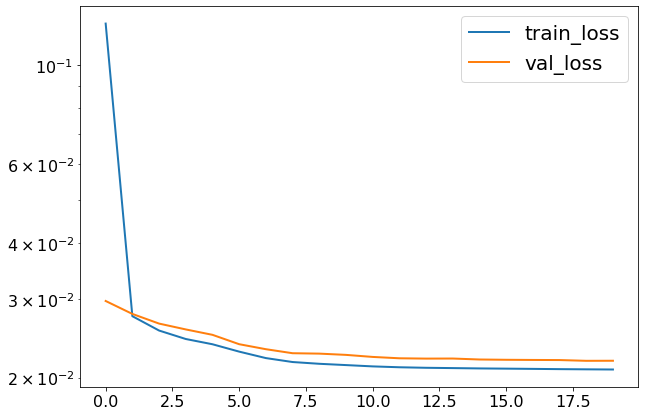

In [12]:
#plot the training loss and the validation loss

plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.yscale('log')
plt.legend()

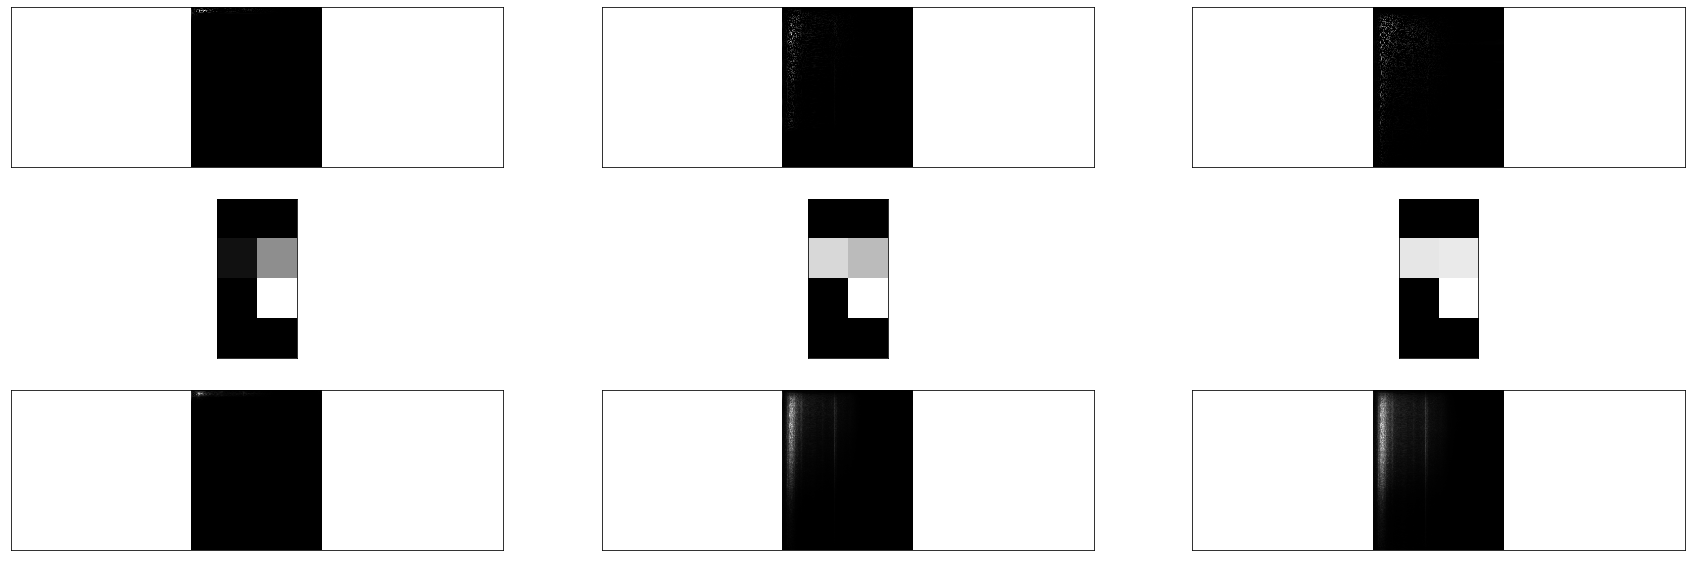

In [13]:
num_images = 3
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(30, 10))
#scalograms are 256 by 512

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(625, 512))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.axis('equal')
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(4,2))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(625, 512))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.axis('equal')
plt.show()


In [14]:
#now put all our data in the encoder why not

#this is coming from dense_4 (will need to adjust if we change the network)

qall_reshape = qall_data.reshape((len(qall_data), np.prod(qall_data.shape[1:])))
encoded_all = encoder.predict(qall_reshape)

print(encoded_all.shape)


(4894, 8)


In [15]:

#Try pca on encoded images why not
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
#need to flatten i guess?
img_pca = pca.fit_transform(encoded_all)

#boundary 1
boundary1 = q003_data.shape[0]

color_key=['red','blue']
color_label=[]
for i in range(qall_data.shape[0]):
    if i < boundary1:
        color_label.append(color_key[0])
    else:
        color_label.append(color_key[1])
        
print(len(color_label))   
print(len(img_pca))

4894
4894


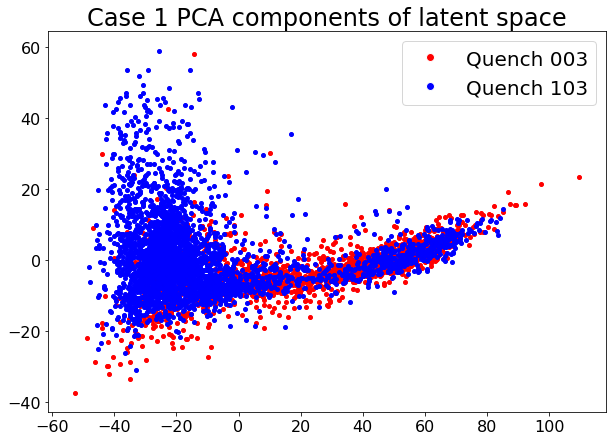

<Figure size 720x504 with 0 Axes>

In [16]:
#try making a nicer figure for maxim

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

msize = 16

#hack the legend together
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Quench 003',
                          markerfacecolor='red', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Quench 103',
                          markerfacecolor='blue', markersize=8)]

# Create the figure and add our hacked legend
plt.figure(figsize=(10, 7))
for i in range(qall_data.shape[0]):
    plt.scatter(img_pca[i,0],img_pca[i,1], color=color_label[i], s=msize)
plt.title('Case 1 PCA components of latent space')
plt.legend(handles=legend_elements)
plt.show()
plt.savefig("pca_norm.png")

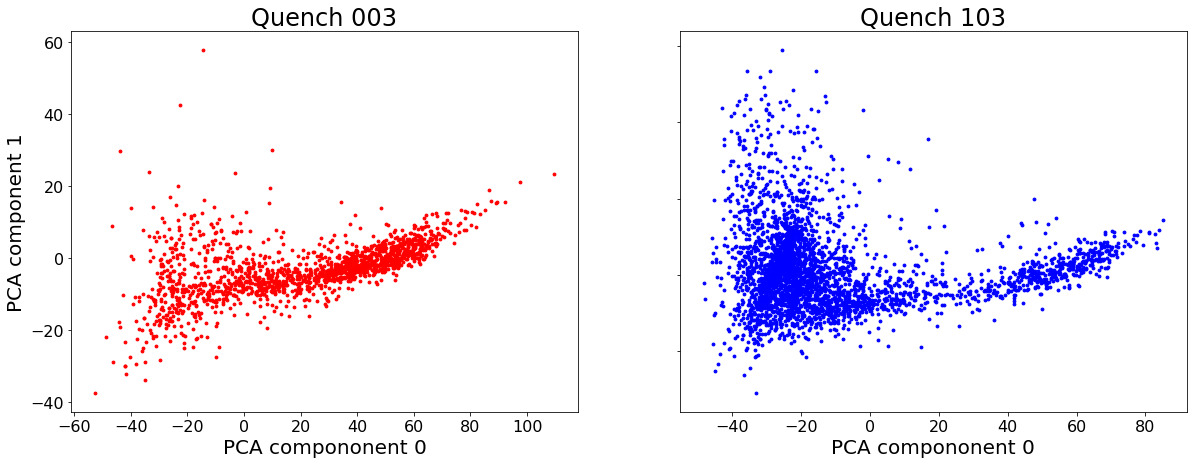

In [17]:
#make the same plot but show all quenches separately

msize = 8

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(20,7)
for i in range(qall_data.shape[0]):
    if color_label[i] == 'red':
        axs[0].scatter(img_pca[i,0],img_pca[i,1], color=color_label[i], s=msize)
        axs[0].set_title('Quench 003')
    else:
        axs[1].scatter(img_pca[i,0],img_pca[i,1], color=color_label[i], s=msize)
        axs[1].set_title('Quench 103')

for ax in axs.flat:
    ax.set(xlabel='PCA compononent 0', ylabel='PCA component 1')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [18]:
#save our encoder AND our trained model!

esave = 'encoder_model_n' + str(n) + '.h5'
asave = 'autoencoder_model_n' + str(n) + '.h5'

encoder.save(esave)
autoencoder.save(asave)